In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
#%matplotlib qt
%matplotlib inline
import collections

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.flag=False
        
        self.detected = False  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=5)
        
        self.detections = collections.deque(maxlen=5)
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
                
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        

        
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None  
        
        self.iteration=0
        
left=Line()
right=Line()

## UNDISTORT FUNCTION

In [3]:
def undistort(img):
    dist_pickle = pickle.load( open( "../calibration_coefficients/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

## THRESHOLDED BINARIES 

In [4]:
def to_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255  #seting red channel to zero
    
    return combined_binary,color_binary

## PERSPECTIVE TRANSFORMATION: WRAP/ UNWARP

### WARP: RETURNS THE BIRDS EYE VIEW

In [5]:
def warp(binary):
    img_size = (binary.shape[1], binary.shape[0])
    offset = 100 # offset for dst points
    src = np.float32([[525.744,499.092],[762.396,499.092],[1046.65,682.505],[261.147,682.505]])
    dst = np.float32([[2*offset, offset], [img_size[0]-2*offset, offset], 
                                     [img_size[0]-2*offset, img_size[1]], 
                                     [2*offset, img_size[1]]]) #2*offset= horizantal clearance on either sides
    ##        1               2
    ##
    ##
    ##        4               3  ## represent order of coordinates in the arguments
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(binary, M, img_size)

    
    return warped, M, Minv

### UNWARP: RETURNS THE NORMAL HORIZONTAL VIEW

In [6]:
def unwarp(binary,Minv):
    img_size = (binary.shape[1], binary.shape[0])
    unwarped = cv2.warpPerspective(binary, Minv, img_size)
    plt.figure()
    plt.imshow(unwarped)
        
    return unwarped
    

## HISTOGRAM

In [7]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

## FITTING POLYNOMIALS FOR LANE PIXELS USING SLIDONG WINDOW

### FINDING LANE PIXEL INDICES USING SLIDING WINDOW

In [40]:
def fit_polynomial_using_sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)    # Create an output image to draw on and visualize the result
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 9    # Choose the number of sliding windows
    margin = 100
    minpix = 50    # Set minimum number of pixels found to recenter window

    window_height = np.int(binary_warped.shape[0]//nwindows)    # Set height of windows - based on nwindows above and image shape
    nonzero = binary_warped.nonzero()    # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base    # Current positions to be updated later for each window in nwindows
    rightx_current = rightx_base

    left_lane_inds = []    # Create empty lists to receive left and right lane pixel indices
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)    # Find our lane pixels first
    left_fit = np.polyfit(lefty, leftx, 2)    # Fit a second order polynomial to each using `np.polyfit`
    right_fit = np.polyfit(righty, rightx, 2)
   
    return left_fit,right_fit,leftx, lefty, rightx, righty


In [65]:
def process_using_sliding_window(binary_warped):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    # Generate x and y values for plottin
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    left_fit,right_fit,leftx, lefty, rightx, righty=fit_polynomial_using_sliding_window(binary_warped)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # Generate x coordinates forplotting polynomial
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.figure()
    plt.title("Lanes Detected using Sliding Window", fontsize=30)
    plt.imshow(out_img)
    #
    plt.plot(left_fitx, ploty, color='yellow')# Plots the left and right polynomials on the lane lines
    plt.plot(right_fitx, ploty, color='yellow')
    
    plt.imsave('../output_images/finding_lanes_using_sliding_window_output.jpg',out_img,cmap='gray')
    
    return left_fit,right_fit,leftx, lefty, rightx, righty


In [66]:
def blindsearch(binary_warped,ploty,left_fit,right_fit):  ## Blindsearch2 in NB2
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    window_img = np.zeros_like(out_img)
    margin=70

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]),(255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]),(0,0, 255))
    result = cv2.bitwise_and(out_img, window_img,  mask=None)
    
    nonzero_left = result[:,:,0].nonzero()
    nonzero_right = result[:,:,2].nonzero()
    
    left_fit_new = np.polyfit(np.array(nonzero_left[0]),np.array(nonzero_left[1]), 2)
    right_fit_new = np.polyfit(np.array(nonzero_right[0]),np.array(nonzero_right[1]), 2)
    
    left_x = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_x = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    
    plt.figure()
    plt.title("Lanes Detected using blind search 2", fontsize=30)
    plt.imshow(window_img)
    
    plt.plot(left_x, ploty, color='yellow')
    plt.plot(right_x, ploty, color='yellow')
    return left_fit_new,right_fit_new,np.array(nonzero_left[1]),np.array(nonzero_left[0]),np.array(nonzero_right[1]),nonzero_right[0]

In [67]:
def process_using_blindsearch(binary_warped,left_fit_from_pf,right_fit_from_pf):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    # Generate x and y values for plottin
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    left_fit,right_fit,leftx, lefty, rightx, righty=blindsearch(binary_warped,ploty,left_fit_from_pf,right_fit_from_pf)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # Generate x coordinates forplotting polynomial
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.figure()
    plt.title("Lanes Detected using Blindsearch ", fontsize=30)
    plt.imshow(out_img)
    
    plt.plot(left_fitx, ploty, color='yellow')# Plots the left and right polynomials on the lane lines
    plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fit,right_fit,leftx, lefty, rightx, righty
    

##  MEASURE REAL CURVATURE

In [68]:


def measure_real_curvature(binary_warped,leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    # Generate x and y values for plottin
    ym_per_pix = 3/200 #30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 #3.7/700 # meters per pixel in x dimension        
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty )
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


In [69]:
def plot_roi(binary_warped,ploty,left_fitx,right_fitx):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    #left_fitx = (left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
    #right_fitx = (right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
    
    pts_left = np.array([np.transpose(np.vstack([list(left_fitx), ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([list(right_fitx), ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    
    return out_img

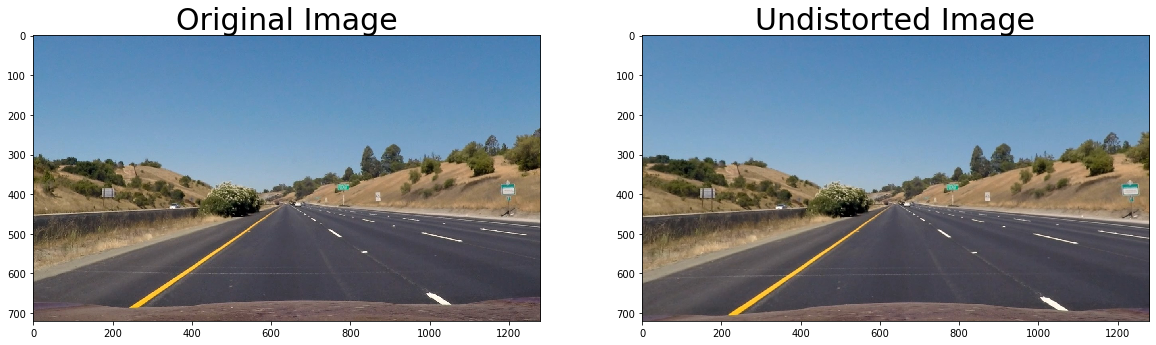

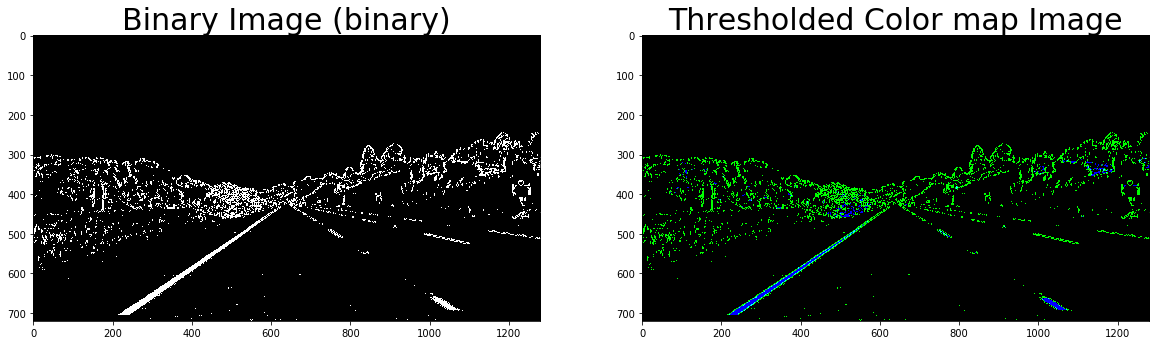

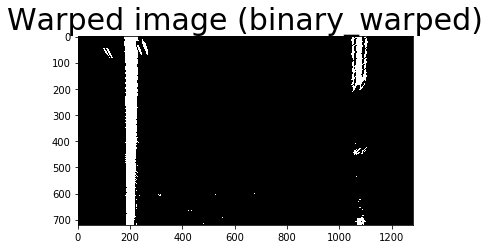

In [76]:
import glob
images = glob.glob("../test_images/straight_lines1*.jpg")


import matplotlib.image as mpimg
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    undst=undistort(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.imsave('../output_images/undistorted.jpg',undst,cmap='gray')

    binary,color_binary=to_binary(undst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(binary,cmap='gray')
    ax1.set_title('Binary Image (binary)', fontsize=30)
    ax2.imshow(color_binary)
    ax2.set_title('Thresholded Color map Image', fontsize=30)
    plt.imsave('../output_images/binary_output.jpg',binary,cmap='gray')
    

    binary_warped, M, Minv=warp(binary)
    plt.figure()
    plt.imshow(binary_warped,cmap='gray')
    #histogram = hist(binary_warped)  # This is only for visulaization
    #plt.plot(histogram,'r', linewidth=3.5)
    plt.title("Warped image (binary_warped)", fontsize=30)
    plt.imsave('../output_images/warped_birds_eye_view.jpg',binary_warped,cmap='gray')

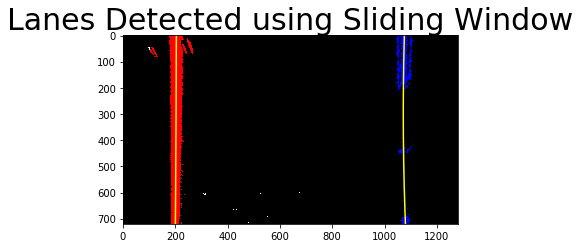

In [77]:
left_fit,right_fit,leftx, lefty, rightx, righty=process_using_sliding_window(binary_warped)


In [73]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [74]:
def process_image(img):
    
    print(left.iteration)  # shows the frame number being iterated
    left.iteration+=1
    undst=undistort(img)  # undistort the image
    binary,color_binary=to_binary(undst) #convert to binary
    binary_warped, M, Minv=warp(binary) # convert to birds eye view
    
    if left.detected==False:  # means last frame was not detected correctly, start from first using sliding window
        left_fit,right_fit,leftx, lefty, rightx, righty=process_using_sliding_window(binary_warped)
        left_curverad, right_curverad=measure_real_curvature(binary_warped,leftx, lefty, rightx, righty)
        print("Detected using sliding window")

    if left.detected == True: # means last frame was detected right, using sliding window or blind search, can continue blind search for this frame
        left_fit,right_fit,leftx, lefty, rightx, righty=process_using_blindsearch(binary_warped,left.current_fit,right.current_fit)
        left_curverad, right_curverad=measure_real_curvature(binary_warped,leftx, lefty, rightx, righty)
        print("Detected using blind serch window")
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )# Generate y coordinates forplotting polynomial
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # Generate x coordinates forplotting polynomial
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    change_percentage=abs(right_curverad-left_curverad)/min(left_curverad,right_curverad)*100
    lane_width_1=abs((left_fit[0]*ploty[0]**2 + left_fit[1]*ploty[0] + left_fit[2])-
    (right_fit[0]*ploty[0]**2 + right_fit[1]*ploty[0] + right_fit[2]))*3.7/900
    
    lane_width_2=abs((left_fit[0]*(img.shape[0]/2)**2 + left_fit[1]*img.shape[0]/2 + left_fit[2])-
    (right_fit[0]*(img.shape[0]/2)**2 + right_fit[1]*img.shape[0]/2 + right_fit[2]))*3.7/900
    
    
    lane_width_3=abs((left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2])-
    (right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]))*3.7/900
    
    if change_percentage>300 or lane_width_1>4 or lane_width_1<3 or lane_width_2>4 or lane_width_2<3 or lane_width_3>4 or lane_width_3<3 or left_curverad>3000 or right_curverad>3000: # false detection
        print("Detected = False")
        if(sum(left.detections)==0):
            left.flag=True
            left.detected=False  # store that this frame failed
        left.detections.append(0) # for detecting continuous 5 failed frames
    else :
        if left.flag==True:
            left.recent_xfitted.clear()
            right.recent_xfitted.clear()
            left.flag=False
            
        print("Detected = True")
        left.detected=True
        left.detections.append(1)
        left.current_fit=left_fit
        right.current_fit=right_fit
        left.recent_xfitted.append(left_fitx)
        #left.recent_yfitted.append(lefty)
        right.recent_xfitted.append(right_fitx)
        #right.recent_yfitted.append(righty)
    
    #averaging last 5 frames
    X_left=np.asarray(left.recent_xfitted)
    X_mean_left=np.mean(X_left,axis=0)
    X_right=np.asarray(right.recent_xfitted)
    X_mean_right=np.mean(X_right,axis=0)


        
    
    roi=plot_roi(binary_warped,ploty,X_mean_left,X_mean_right)
    roi_unwarped=unwarp(roi,Minv)    
    
    image_center=img.shape[1]//2
    lane_center=(left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]+
    right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2])//2
    offset=np.abs(image_center-lane_center)*3.7/900
    
    string1=("Offset="+ "{:.2f}".format(offset)+'m')
    #string1=("{:.2f}".format(lane_width_3)+" {:.2f}".format(lane_width_1))
    
    string2=("Curvature="+ "{:.1f}".format((left_curverad+ right_curverad)/2)+'m')
    #string2=("L.Curvature="+ "{:.1f}".format(left_curverad)+'m')
    #string3=("R.Curvature="+ "{:.1f}".format( right_curverad)+'m')
   
            
    print("lane widths:",lane_width_3,lane_width_1,lane_width_2)
    print('Real world left_curverad,right_curverad=',left_curverad,right_curverad)
    print("Percentage change:",change_percentage)
   
    result = cv2.addWeighted(img, 1, roi_unwarped, 0.3, 0)
    cv2.putText(result, string1,(300,150),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0) ,7 )
    cv2.putText(result, string2,(200,250),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0) ,7 )
    plt.imsave('../output_images/final_img.jpg',result,cmap='gray')
    return result
    


    #attrs = vars(left)
    # {'kids': 0, 'name': 'Dog', 'color': 'Spotted', 'age': 10, 'legs': 2, 'smell': 'Alot'}
    # now dump this in some way or another
    ##print(',\n '.join("%s: %s" % item for item in attrs.items()))
        

0
Detected using sliding window
Detected = True
lane widths: 3.6089189852801757 3.5458024451808874 3.6377754929522537
Real world left_curverad,right_curverad= 391.5961456907299 149.34933879416232
Percentage change: 162.201459244784
Moviepy - Building video ../output_Videos/project_video_output1.mp4.
Moviepy - Writing video ../output_Videos/project_video_output1.mp4



t:   0%|                                                                               | 0/3 [00:00<?, ?it/s, now=None]

1
Detected using blind serch window
Detected = False
lane widths: 3.586110028473971 3.5411007081765558 3.638533060547893
Real world left_curverad,right_curverad= 641.8329546056733 149.34933879418207
Percentage change: 329.75279287321223


t:  67%|███████████████████████████████████████████████▎                       | 2/3 [00:00<00:00,  5.49it/s, now=None]

2
Detected using blind serch window
Detected = False
lane widths: 3.6277794162310553 3.569828384048514 3.6479203140030183
Real world left_curverad,right_curverad= 977.5261673948235 227.68528522493574
Percentage change: 329.33216629660626


t: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s, now=None]

3
Detected using blind serch window
Detected = True
lane widths: 3.651279492782614 3.520059362755875 3.6317029254225606
Real world left_curverad,right_curverad= 788.3803778876912 225.9519378126305
Percentage change: 248.91507703795472


Moviepy - Done !
Moviepy - video ready ../output_Videos/project_video_output1.mp4
Wall time: 2.52 s


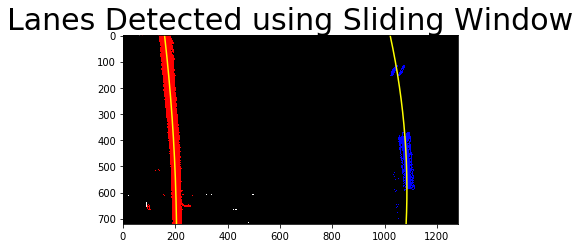

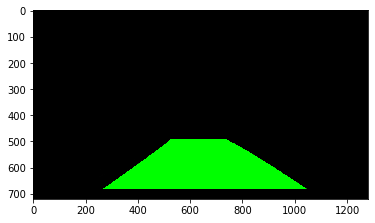

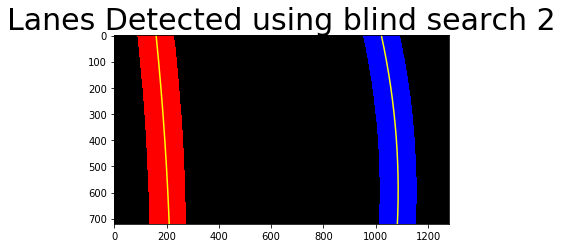

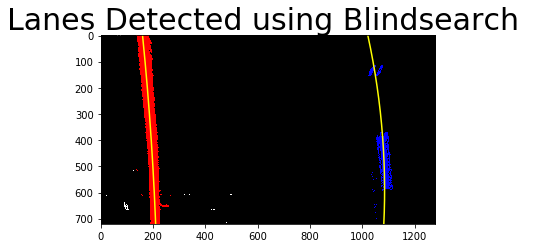

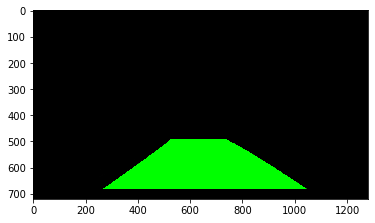

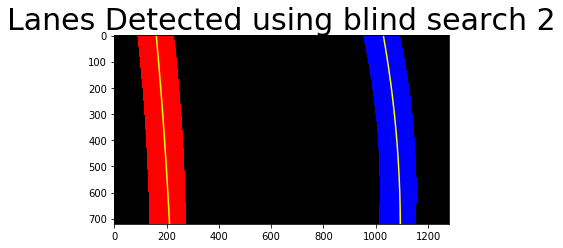

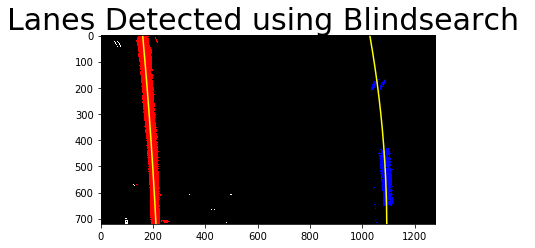

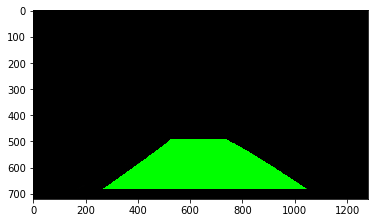

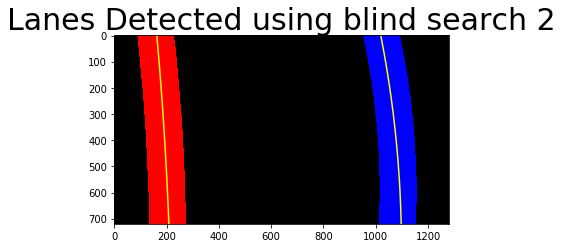

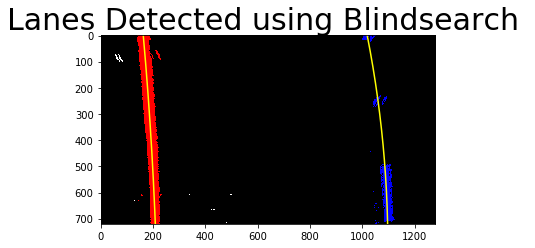

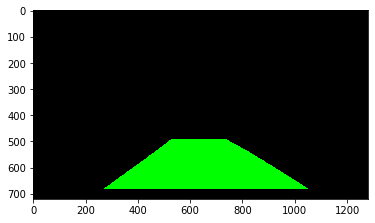

In [75]:
#left.iteration=0
    
video_output = '../output_Videos/project_video_output1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4").subclip(10,10.1)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)
  